# Predicting Schizophrenia Diagnosis

This notebooks contains an analysis of the COBRE dataset available on Nilearn. The dataset contains resting state fMRI data from 146 participants. Approximately half of the subjects are patients diagnosed with schizophrenia and the remainder are healthy controls. The anlaysis in this notebook attempt to predict schizophrenia diagnosis using resting state fMRI data.

In [ ]:
#import data
from nilearn import datasets
data = datasets.fetch_cobre(n_subjects=None)

Phenotypic info for the subjects is included with the data ut requires some cleaning first.

In [2]:
#import phenotypic data
import pandas
pheno = pandas.DataFrame(data.phenotypic)

We'll extract subject ID from the niifti file names using index slicing and then merge the fMRI file paths to the phenotypic data.

In [3]:
#extract participant id from file paths
file_names = []
for path in data.func:
    
    file_names.append(path[40:45])

In [4]:
#create dataframe of file paths and ids
files = pandas.DataFrame(data.func, columns = ['path'])
files['id'] = file_names
files['id'] = files.id.astype(int)

In [5]:
#merge phenotypic data with file paths
import pandas
pheno = pandas.merge(pheno, files, on = 'id')

#fix string decoding
pheno['gender'] = pheno['gender'].map(lambda x: x.decode('utf-8'))
pheno['handedness'] = pheno['handedness'].map(lambda x: x.decode('utf-8'))
pheno['subject_type'] = pheno['subject_type'].map(lambda x: x.decode('utf-8'))
pheno['diagnosis'] = pheno['diagnosis'].map(lambda x: x.decode('utf-8'))

Let's take a look at what we have now. And also sve the cleaned phenotypic data to a csv.

In [6]:
#pheno.to_csv('pheno.csv', index=False)
pheno

,id,current_age,gender,handedness,subject_type,diagnosis,frames_ok,fd,fd_scrubbed,path
0,40061,18,Male,Right,Control,None,133,0.25512,0.22657,/home/aalbury/nilearn_data/cobre/fmri_0040061....
1,40090,18,Female,Right,Control,None,150,0.16963,0.16963,/home/aalbury/nilearn_data/cobre/fmri_0040090....
2,40046,18,Male,Left,Patient,295.70 depressed type,76,0.37504,0.30042,/home/aalbury/nilearn_data/cobre/fmri_0040046....
3,40002,19,Male,Right,Patient,295.3,67,0.40006,0.21575,/home/aalbury/nilearn_data/cobre/fmri_0040002....
4,40117,19,Male,Right,Patient,295.3,133,0.20975,0.18410,/home/aalbury/nilearn_data/cobre/fmri_0040117....
...,...,...,...,...,...,...,...,...,...,...
141,40089,62,Male,Right,Patient,295.3,40,0.70368,0.72439,/home/aalbury/nilearn_data/cobre/fmri_0040089....
142,40040,63,Male,Right,Patient,295.3,42,0.58301,0.40646,/home/aalbury/nilearn_data/cobre/fmri_0040040....
143,40028,64,Male,Right,Patient,295.3,55,0.42364,0.26393,/home/aalbury/nilearn_data/cobre/fmri_0040028....
144,40086,65,Male,Right,Control,None,48,0.39595,0.32296,/home/aalbury/nilearn_data/cobre/fmri_0040086....


Now that we have the file paths matched with the phenotypic data, we can easily make subsets for patients and controls.

In [7]:
#create lists of filepaths for patients and controls
patients = []
controls = []

for i in pheno.index:
    if pheno.loc[i, 'subject_type']=='Patient':
    
        patients.append(pheno.loc[i, 'path'])
    else:
        controls.append(pheno.loc[i, 'path'])


The code below generates an interactive app using plotly express that will plot a histogram of subject age.

In [8]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
# Load Data
df = pheno
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Age"),
    dcc.Graph(id='graph'),
    html.Label([
        "Participant type",
        dcc.Dropdown(
            id='subject_type', clearable=False,
            value='Patient', options=[
                {'label': c, 'value': c}
                for c in df.subject_type.unique() #get all unique values from column
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("subject_type", "value")]
)
def update_figure(subject_type):
    return px.histogram(
        df[df["subject_type"]==subject_type], x="current_age", color="gender"
        
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

## Connectivity

This anlaysis uses the BASC atlas to defin ROIs. We'll focus on 64 ROIs for this analysis.

In [9]:
#import atlas
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

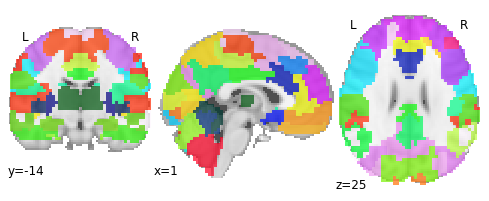

In [10]:
# visualize atlas
from nilearn import plotting
plotting.plot_roi(atlas_filename, draw_cross = False)

Let's generate correlation matrices for each subject and then merge them to the phenotypic data.

In [11]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# create mask
mask = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

# initialize correlation measure
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

In [12]:
import pandas as pd

#initialize empty dataframe
all_features = pd.DataFrame(columns=['features', 'file'])

for i,sub in enumerate(data.func):
    # extract the timeseries from the ROIs in the atlas
    time_series = mask.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add features and file name to dataframe
    all_features = all_features.append({'features': correlation_matrix, 'file': data.func[i]}, ignore_index=True)
    # uncomment below to keep track of status
    #print('finished %s of %s'%(i+1,len(data.func)))

[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064

[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabe

[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabe

[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabelsMasker.fit_transform] loading data from /home/aalbury/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[NiftiLabe

In [13]:
# create pandas dataframe of features and phenotypic data
full = pandas.merge(pheno, all_features, left_on = 'path', right_on = 'file')

Now we have a Pandas dataframe with all of our demographic data and a column that contains the correlation matrix for each subject as an array.

In [14]:
full

,id,current_age,gender,handedness,subject_type,diagnosis,frames_ok,fd,fd_scrubbed,path,features,file
0,40061,18,Male,Right,Control,None,133,0.25512,0.22657,/home/aalbury/nilearn_data/cobre/fmri_0040061....,"[0.12785325357282862, 0.24422311479417322, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040061....
1,40090,18,Female,Right,Control,None,150,0.16963,0.16963,/home/aalbury/nilearn_data/cobre/fmri_0040090....,"[0.05584897620355883, 0.11246991477285287, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040090....
2,40046,18,Male,Left,Patient,295.70 depressed type,76,0.37504,0.30042,/home/aalbury/nilearn_data/cobre/fmri_0040046....,"[0.08678037911430761, 0.06380639929297223, 0.2...",/home/aalbury/nilearn_data/cobre/fmri_0040046....
3,40002,19,Male,Right,Patient,295.3,67,0.40006,0.21575,/home/aalbury/nilearn_data/cobre/fmri_0040002....,"[0.1456258349041035, -0.06313977045762048, 0.0...",/home/aalbury/nilearn_data/cobre/fmri_0040002....
4,40117,19,Male,Right,Patient,295.3,133,0.20975,0.18410,/home/aalbury/nilearn_data/cobre/fmri_0040117....,"[0.17462308889197792, -0.11825290188441862, -0...",/home/aalbury/nilearn_data/cobre/fmri_0040117....
...,...,...,...,...,...,...,...,...,...,...,...,...
141,40089,62,Male,Right,Patient,295.3,40,0.70368,0.72439,/home/aalbury/nilearn_data/cobre/fmri_0040089....,"[0.010289989396440208, 0.05385253837186407, 0....",/home/aalbury/nilearn_data/cobre/fmri_0040089....
142,40040,63,Male,Right,Patient,295.3,42,0.58301,0.40646,/home/aalbury/nilearn_data/cobre/fmri_0040040....,"[-0.05942811380550243, 0.005379451667081145, 0...",/home/aalbury/nilearn_data/cobre/fmri_0040040....
143,40028,64,Male,Right,Patient,295.3,55,0.42364,0.26393,/home/aalbury/nilearn_data/cobre/fmri_0040028....,"[0.1526906170886252, 0.2197449376315366, 0.301...",/home/aalbury/nilearn_data/cobre/fmri_0040028....
144,40086,65,Male,Right,Control,None,48,0.39595,0.32296,/home/aalbury/nilearn_data/cobre/fmri_0040086....,"[0.44868677474053265, -0.1957847795785304, -0....",/home/aalbury/nilearn_data/cobre/fmri_0040086....


### Visualizing Connectivity

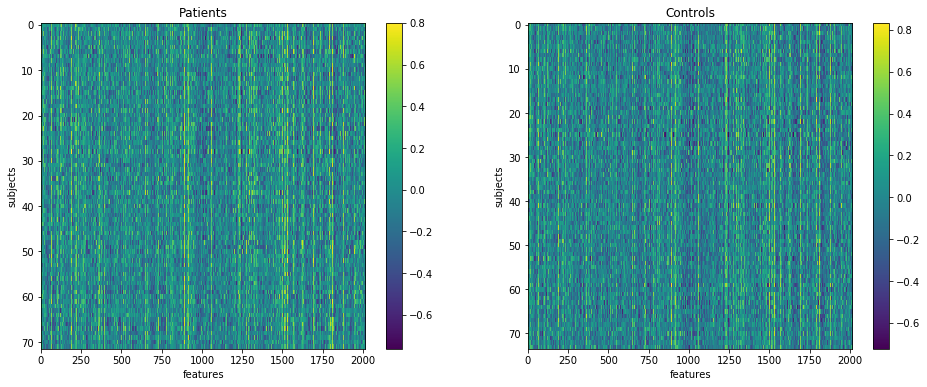

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig

patient_features = list(full.loc[full['subject_type']=='Patient']['features'])
control_features = list(full.loc[full['subject_type']=='Control']['features'])

figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.imshow(patient_features, aspect='auto')
plt.colorbar()
plt.title('Patients')
plt.xlabel('features')
plt.ylabel('subjects')


plt.subplot(1, 2, 2)
plt.imshow(control_features, aspect='auto')
plt.colorbar()
plt.title('Controls')
plt.xlabel('features')
plt.ylabel('subjects')

savefig('features.png', transparent=True)

## Classification

This section contains the main analysis of this notebook. Namely, predicting schizophrenia diagnosis. The features used are the correlation matrices generated previously, and diagnosis labels are contained in the `subject_type` column from our phenotypic data.

We first split the data into training and validation sets, with a ratio of 80/20.

In [16]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 80/20 ratio

x_train, x_val, y_train, y_val = train_test_split(
                                                    list(full['features']), # x
                                                    full['subject_type'], # y
                                                    test_size = 0.2, # 80%/20% split  
                                                    shuffle = True, # shuffle dataset
                                                    stratify = full['subject_type'],
                                                    random_state = 242 
                                                                       )

Our starting classifier with be a linear support vector machine, specified as `SVC()` in Nilearn. This is often the [first recommendation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) for clssification problems with small sample sizes. 

We'll be using 10-fold corss validation to get a rough benchmark of performance for each classifier. We'll use F1 as our performance metric. After each run we'll look at the preformance of the classifier across the folds as well as the average performance.

In [17]:
# build SVC classifier
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [18]:
# F1 score by averaging each fold
from sklearn.model_selection import cross_val_score
import numpy as np
svc_score = cross_val_score(svc, x_train, y_train, cv=10, scoring = 'f1_macro')
print(np.mean(svc_score))
print(svc_score)

0.7981132756132755
[0.82857143 0.74825175 0.74825175 0.74825175 1.         0.74825175
 0.90598291 0.81666667 0.80357143 0.63333333]


Linear SCV seems to perform very strongly, with an average F1 score of ~0.80

We'll try gradient boosting next. The gradient boost model will use a greater number of estimators and a larger max depth than the defaults in order to try and improve performance.

In [19]:
# build gradient boost classifier
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=500,
                                   max_depth=4, 
                                   random_state=242
                                  )

In [20]:
#train model
boost.fit(x_train, y_train)

# F1 score by averaging each fold
from sklearn.model_selection import cross_val_score
import numpy as np
boost_score = cross_val_score(boost, x_train, y_train, cv=10, scoring = 'f1_macro')
print(np.mean(boost_score))
print(boost_score)

0.5752838827838829
[0.48571429 0.5        0.74825175 0.625      0.24475524 0.82857143
 0.60714286 0.71794872 0.54545455 0.45      ]


The gradient boost model seems to be highly variable and doesn't come close to matching the performance of the SVC. 
We'll try K Nearest Neighbors next.

In [21]:
# K Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_score = cross_val_score(knn, x_train, y_train, cv=10, scoring = 'f1_macro')
print(np.mean(knn_score))
print(knn_score)

0.6219476356976357
[0.73333333 0.625      0.58041958 0.48571429 0.48571429 0.4375
 0.71794872 0.71794872 0.71794872 0.71794872]


K Nearest Neighbors performs poorly with default paramaters. Given the large difference between KNN and the other classifiers I won't try to tweak this alogrithm.

Lastly we'll try a Random Forest classifier. We'll increase the numebr of estimators like we did with the gradient boost model.

In [22]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 500, random_state = 242)

rfc_score = cross_val_score(rfc, x_train, y_train, cv=10, scoring = 'f1_macro')
print(np.mean(rfc_score))
print(rfc_score)

0.7322227772227772
[0.83333333 0.73333333 0.65714286 0.58041958 0.74825175 0.91608392
 0.68571429 0.81666667 0.63333333 0.71794872]


The Random Forest model seems to perform well but not as well as the linear SVC. With some hyperparameter tweaking it might be possible to achieve the same performance but considering the random forest classifier is more complex, and takes longer to train, we'll use SVC as the final model.

### Hyperparameter Tuning

Now that we've committed to a model, let's see if we can get a little more out of it by tweaking the hyperparameters. Unfortunately, the only option for a linear SVC is the `C` parameter.

We can create a range of values for `C` and then compare each using cross validation.

In [23]:
from sklearn.model_selection import validation_curve

C_range = 10. ** np.arange(-3, 8) # A range of different values for C

train_scores, valid_scores = validation_curve(svc, x_train, y_train, 
                                              param_name= "C",
                                              param_range = C_range,
                                              cv=10,
                                             scoring='f1_macro')

In [24]:
# Creating a Pandas dataframe of the results
tScores = pandas.DataFrame(train_scores).stack().reset_index()
tScores.columns = ['C','Fold','Score']
tScores.loc[:,'Type'] = ['Train' for x in range(len(tScores))]

vScores = pandas.DataFrame(valid_scores).stack().reset_index()
vScores.columns = ['C','Fold','Score']
vScores.loc[:,'Type'] = ['Validate' for x in range(len(vScores))]

ValCurves = pandas.concat([tScores,vScores]).reset_index(drop=True)

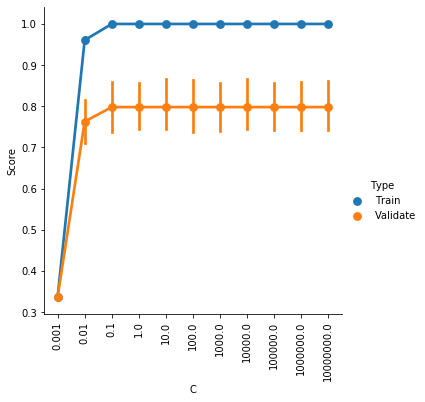

In [25]:
# Plotting the performance of different values of C
import seaborn as sns
g = sns.catplot(x='C', y='Score', hue='Type', data=ValCurves, kind='point')

g.set_xticklabels(C_range, rotation=90)

The best performance seems to be at a C value of 0.1 but it's a negligible difference. But there's one more thing to try.

What if we changed the SVC kernel to the default 'rbf' which would let us adjust C and gamma? Let's use a grid search to see if optimizing an rbf kernel would perform better than a linear kernel.

In [26]:
# RBF SVC model
from sklearn.model_selection import GridSearchCV

svc_rbf = SVC(kernel='rbf')

C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-8, 3)

param_grid = dict(gamma=gamma_range, C=C_range)

grid = GridSearchCV(svc_rbf, param_grid=param_grid, cv=10)

grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
print(grid.best_params_)

{'C': 100.0, 'gamma': 0.001}


In [28]:
svc_rbf = SVC(kernel='rbf', C=100.0, gamma=0.001)

svc_rbf_score = cross_val_score(svc_rbf, x_train, y_train, cv=10, scoring = 'f1_macro')
print(np.mean(svc_rbf_score))
print(svc_rbf_score)

0.8061452436452436
[0.82857143 0.82857143 0.74825175 0.74825175 1.         0.74825175
 0.90598291 0.81666667 0.80357143 0.63333333]


It seems like SVC with an RBF kernel and tuned hyperparameters performs slightly better than linear SVC, so we'll use this as the final model.

### Testing The Model

We can now run the model on the left out data and see how it performs.

In [29]:
# Validation
from sklearn.metrics import f1_score, accuracy_score
svc_rbf.fit(x_train, y_train)
final_pred = svc_rbf.predict(x_val)
print('F1:', f1_score(y_val, final_pred, pos_label='Patient'))
print('Accuracy:', accuracy_score(y_val, final_pred))

F1: 0.6875
Accuracy: 0.6666666666666666


An F1 score of .69 isn't too bad for a binary classification problem. Let's see how the model is handling the labels by taking a look at the confusion matrix.

[[ 9  6]
 [ 4 11]]


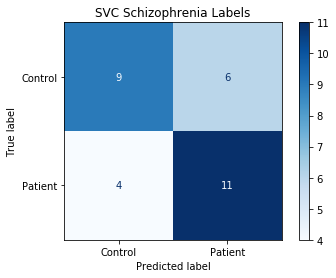

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(svc_rbf, x_val, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('SVC Schizophrenia Labels')

print(disp.confusion_matrix)

The model seems to handle each class equally well.

## Predicting Schizophrenia Subtype

The phenotypic data also includes the schizophrenia subtype that each patient was diagnosed with. Maybe we can predict subtype as well. Let's take a look at how they are distributed.

In [31]:
full.diagnosis.value_counts()

None                     72
295.3                    41
295.6                    12
295.7                     5
295.9                     5
295.1                     3
296.26                    1
296.4                     1
290.3                     1
295.92                    1
311                       1
295.70 bipolar type       1
295.70 depressed type     1
295.2                     1
Name: diagnosis, dtype: int64

The distribution of schizohprenia subtypes seems highly unbalanced. Most of the patients were diagnosed with the label "295.3" which refers to paranoid schizophrenia. There are very few observations for the other subtypes and so it's unlikely that any model could predict these with so little data. Maybe we can predict paranoid schizophrenia from the other subtypes.

In [32]:
# creating a new variable for subtype
diagnosis=[]

for i in full.index:
    if full.loc[i, 'diagnosis']=='295.3':
        diagnosis.append('Paranoid')
    elif full.loc[i, 'diagnosis']=='None':
        diagnosis.append('None')
    else:
        diagnosis.append('Other')
        
full['type'] = diagnosis

We'll split the data again. Stratified by our new subtype variable.

In [33]:
from sklearn.model_selection import train_test_split

# Split the sample to training/validation with a 80/20 ratio

x_train2, x_val2, y_train2, y_val2 = train_test_split(
                                                    list(full['features']), # x
                                                    full['type'], # y
                                                    test_size = 0.2, # 80%/20% split  
                                                    shuffle = True, # shuffle dataset
                                                    stratify = full['type'],
                                                    random_state = 242 
                                                                       )

Let's avoid running all of the models separately again. It would be much easier to compare a lot of models at once. The cell below defines several models and then loops over them to generate cross validated performance metrics. A more detailed example of this can be found [here]().

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

np.random.seed(242)

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

for name, clf in zip(names, classifiers):
        
        score = cross_val_score(clf, x_train2, y_train2, cv=10, scoring='f1_macro')
        
        print(name, np.mean(score))

Nearest Neighbors 0.39345543345543355
Linear SVM 0.4076200651200651
RBF SVM 0.21960784313725487
Gaussian Process 0.1431135531135531
Decision Tree 0.34980260480260483
Random Forest 0.36240516564045977
Neural Net 0.3840762723115664
AdaBoost 0.3908056540409482
Naive Bayes 0.41458892958892957


A Gaussian Naive Bayes model performs slightly better than linear SVC, so we'll use it in this case. But I think this is another example of how powerful SVM is as an approach.

In [35]:
# Validation
NB = GaussianNB()

NB.fit(x_train2, y_train2)
type_pred = NB.predict(x_val2)
f1_score(y_val2, type_pred, average='macro')

0.4464646464646464

[[10  3  2]
 [ 4  3  0]
 [ 4  2  2]]


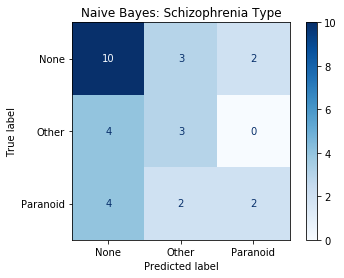

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


disp = plot_confusion_matrix(NB, x_val2, y_val2,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Naive Bayes: Schizophrenia Type')


print(disp.confusion_matrix)

It seems like the model is performing very well predicting controls, but poorly differentiating schizophrenia patients.